In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
from scipy.spatial import distance
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

import pandas as pd
from nltk.tokenize import word_tokenize
import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.decomposition import PCA

Using TensorFlow backend.


In [2]:
def my_cleaner(post):      
    s= re.sub(r"http\S+", " http ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) 
    s= re.sub(r'@\w+ ?', " user ", s)    
    s= s.lower()
    sl= list(s.split())  
    return s, sl

def get_EMB_sent(idd_sent, input_ids, base_BERT_space):
    token_vectors = [base_BERT_space[token_id] for token_id in input_ids[idd_sent]]
    
    return np.mean(token_vectors, axis=0)

In [3]:
train= pd.read_csv('../Fine-Tuning/CSV_Stance/train_semeval_raw.csv')
sents_train= train['Tweet'].values
val= pd.read_csv('../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv')
sents_val= val['Tweet'].values
test= pd.read_csv('../Fine-Tuning/CSV_Stance/test_semeval_raw.csv')
sents_test= test['Tweet'].values

In [4]:
model_loaded = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4) 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_loaded.cuda()
base_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
base_BERT_space.shape

(30522, 768)

### Training sentences

In [5]:
idx_2_token = tokenizer.ids_to_tokens

input_ids = []
for sent in sents_train:    
    myc, myc_list= my_cleaner(sent)
    encoded_sent = tokenizer.encode(myc, add_special_tokens = True)
    input_ids.append(encoded_sent)

BERT_train=np.zeros((train.shape[0], base_BERT_space.shape[-1]))
for i in range(train.shape[0]):
    BERT_train[i]=get_EMB_sent(i, input_ids, base_BERT_space)

In [6]:
out = '../../model_save/Dos-Fases-all/' 
model_trained = BertForSequenceClassification.from_pretrained(out, num_labels=4) 
tokenizer_trained = BertTokenizer.from_pretrained(out, do_lower_case=True)
model_trained.cuda()
trained_BERT_space = model_trained.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
trained_BERT_space.shape

(30522, 768)

In [8]:
idx_2_token_trained = tokenizer_trained.ids_to_tokens

input_ids_trained = []
for sent in sents_train:    
    myc, myc_list= my_cleaner(sent)
    encoded_sent = tokenizer_trained.encode(myc, add_special_tokens = True)
    input_ids_trained.append(encoded_sent)

BERT_train_loaded=np.zeros((train.shape[0], trained_BERT_space.shape[-1]))
for i in range(train.shape[0]):
    BERT_train_loaded[i]=get_EMB_sent(i, input_ids_trained, trained_BERT_space)

In [9]:
def visualize_dims(data, labels):
    mask_q = (labels=="questioning")
    mask_s = (labels=="support") 
    mask_c = (labels=="commenting")
    mask_d = (labels=="denying") 
    
    model = KernelPCA(2, kernel='rbf', gamma=0.01, n_jobs=-1)  #linear” | “poly” | “rbf” 
    to_plot_kpca = model.fit_transform(data)    
    
    plt.figure(figsize=(10,7))
    plt.scatter(to_plot_kpca[:,0][mask_c],to_plot_kpca[:,1][mask_c], label="commenting")
    plt.scatter(to_plot_kpca[:,0][mask_q],to_plot_kpca[:,1][mask_q], label="questioning")
    plt.scatter(to_plot_kpca[:,0][mask_s],to_plot_kpca[:,1][mask_s], label="support")
    plt.scatter(to_plot_kpca[:,0][mask_d],to_plot_kpca[:,1][mask_d], label="denying")
    
    plt.legend()
    plt.title("train-sentences")
    plt.show()

    return to_plot_kpca

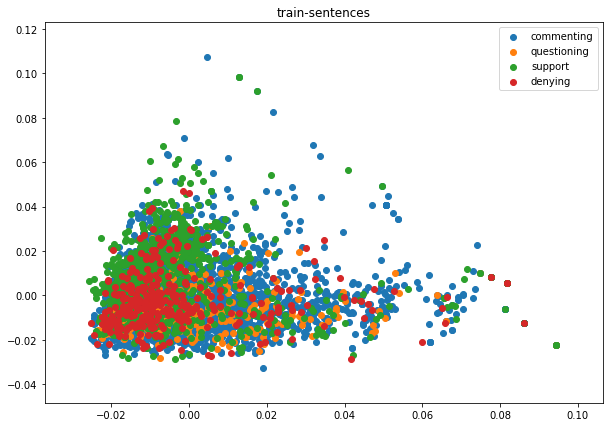

In [12]:
from sklearn.decomposition import KernelPCA

labels = train['Label'].values
to_plot_kpca = visualize_dims(BERT_train, labels)

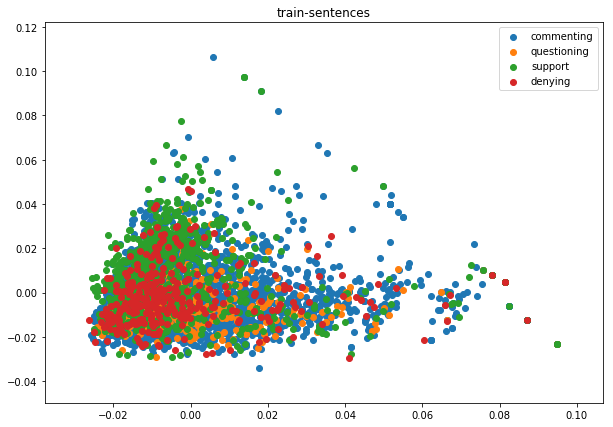

In [13]:
labels = train['Label'].values
to_plot_kpca = visualize_dims(BERT_train_loaded, labels)

In [15]:
BERT_train_loaded - BERT_train

array([[ 0.00367628,  0.00268628, -0.00592352, ...,  0.0012737 ,
        -0.00380369,  0.00236494],
       [ 0.00155636,  0.00167281, -0.00344513, ...,  0.00105465,
        -0.00232818,  0.00116862],
       [ 0.00257697,  0.00142184, -0.0036313 , ...,  0.00070185,
        -0.00305915,  0.00147176],
       ...,
       [ 0.0015143 ,  0.00137923, -0.00325161, ...,  0.00049275,
        -0.00265529,  0.00047084],
       [ 0.00106553,  0.00063481, -0.00217627, ...,  0.00046925,
        -0.00158811,  0.00035217],
       [ 0.00211221,  0.00112617, -0.00328081, ...,  0.00092783,
        -0.00181943,  0.00126615]])

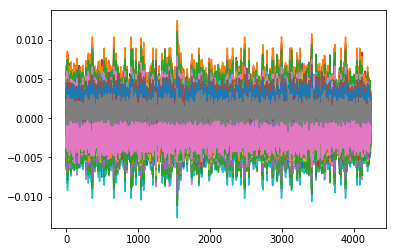

In [16]:
plt.plot(BERT_train_loaded - BERT_train)
plt.show()

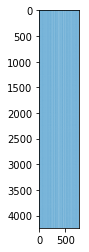

In [20]:
diff= BERT_train_loaded - BERT_train
plt.figure(figsize=(8,5))
plt.imshow(diff, cmap='Blues', alpha=.9, interpolation='bilinear')
plt.show()

In [24]:
def visualize_dims_tsne(data, labels, title):
    mask_q = (labels=="questioning")
    mask_s = (labels=="support") 
    mask_c = (labels=="commenting")
    mask_d = (labels=="denying") 
    
    model = TSNE(2, metric='euclidean')
    to_plot_tsne = model.fit_transform(data)   
    
    plt.figure(figsize=(10,7))
    plt.scatter(to_plot_tsne[:,0][mask_c],to_plot_tsne[:,1][mask_c], label="commenting")
    plt.scatter(to_plot_tsne[:,0][mask_q],to_plot_tsne[:,1][mask_q], label="questioning")
    plt.scatter(to_plot_tsne[:,0][mask_s],to_plot_tsne[:,1][mask_s], label="support")
    plt.scatter(to_plot_tsne[:,0][mask_d],to_plot_tsne[:,1][mask_d], label="denying")
    
    plt.legend()
    plt.title(title)
    plt.show()

    return to_plot_tsne


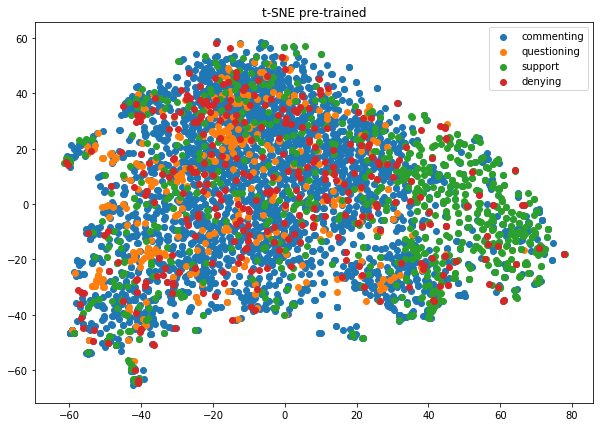

In [25]:
from sklearn.manifold import TSNE 

labels = train['Label'].values
to_plot_tsne = visualize_dims_tsne(BERT_train, labels, 't-SNE pre-trained')

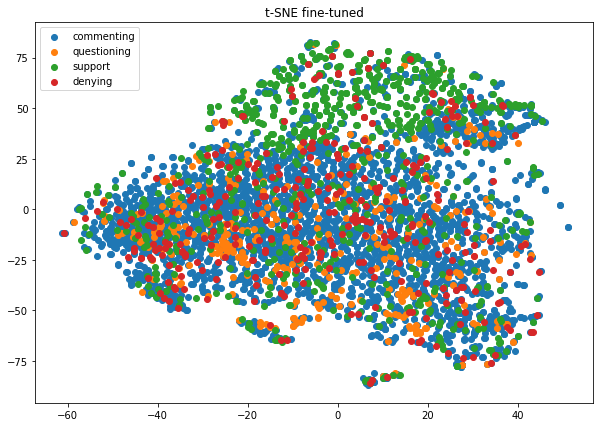

In [26]:
labels = train['Label'].values
to_plot_tsne = visualize_dims_tsne(BERT_train_loaded, labels, 't-SNE fine-tuned')

In [28]:
diff_to_pre= ( BERT_train_loaded - BERT_train ) / BERT_train
diff_to_pre

array([[-0.12532775, -0.14582831,  0.25361009, ..., -0.06419754,
         1.4341866 , -0.52423048],
       [-0.05888795, -0.12730833,  0.63207665, ..., -0.58881803,
        -0.26969165, -0.34413872],
       [-0.28380277, -0.06099439,  0.16294907, ..., -0.35622031,
        -4.04252499, -0.300281  ],
       ...,
       [-0.11835427, -0.05549397,  0.89811995, ..., -0.04254011,
         0.3913365 , -0.02219781],
       [-0.06700639, -0.02157695,  0.105444  , ..., -0.03812208,
         0.27054588, -0.02710558],
       [-0.10910572, -0.06711456,  0.376541  , ..., -0.18644354,
         0.27030866,  0.91434627]])

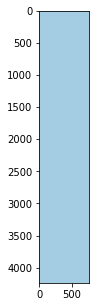

In [34]:
plt.figure(figsize=(8,5))
plt.imshow(diff_to_pre, cmap='Blues', alpha=.9, interpolation='bilinear')
plt.show()